In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
from pathlib import Path
import os
import sys

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import xarray as xr

import seaborn as sns
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import calendar
import glob
import itertools

import math
import geopandas as gpd

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.indicators.drought.ecmwf_seasonal import processing
reload(processing)

mpl.rcParams['figure.dpi'] = 200
pd.options.mode.chained_assignment = None
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

In [3]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_iso3=parameters["iso3_code"]

country_data_raw_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR, config.RAW_DIR,country_iso3)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,config.PROCESSED_DIR,country_iso3)
country_data_exploration_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,"exploration",country_iso3)
chirps_country_data_exploration_dir= os.path.join(config.DATA_DIR,config.PUBLIC_DIR, "exploration", country_iso3,'chirps')

chirps_monthly_mwi_path=os.path.join(chirps_country_data_exploration_dir,"chirps_mwi_monthly.nc")
ecmwf_country_data_processed_dir = os.path.join(country_data_processed_dir,"ecmwf")
ecmwf_country_data_raw_dir = os.path.join(country_data_raw_dir,"ecmwf")
monthly_precip_exploration_dir=os.path.join(country_data_exploration_dir,"dryspells","monthly_precipitation")

plots_dir=os.path.join(country_data_processed_dir,"plots","dry_spells")
plots_seasonal_dir=os.path.join(plots_dir,"seasonal")

adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])
all_dry_spells_list_path=os.path.join(country_data_processed_dir,"dry_spells","full_list_dry_spells.csv")
monthly_precip_path=os.path.join(country_data_processed_dir,"chirps","seasonal","chirps_monthly_total_precipitation_admin1.csv")
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])

In [4]:
ds=processing.get_ecmwf_forecast(country_iso3)

In [5]:
ds

<xarray.Dataset>
Dimensions:     (latitude: 13, longitude: 10, number: 51, step: 6, time: 341)
Coordinates:
  * number      (number) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * time        (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2021-05-01
  * step        (step) int64 1 2 3 4 5 6
    surface     float64 0.0
  * latitude    (latitude) float64 -7.126 -8.126 -9.126 ... -17.13 -18.13 -19.13
  * longitude   (longitude) float64 29.67 30.67 31.67 ... 36.67 37.67 38.67
    valid_time  (time, step) datetime64[ns] 1993-02-01 1993-03-01 ... 2021-11-01
Data variables:
    tprate      (time, number, step, latitude, longitude) float32 9.162e-08 ....
    precip      (time, number, step, latitude, longitude) float64 245.4 ... 1...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-06-07T12:41 GRIB to CDM+CF via cfgrib-0.9.9...

In [6]:
#not using the tprate variable, so drop
ds=ds.drop("tprate")

In [7]:
# ds.sel(latitude=ds.latitude[5],longitude=ds.longitude[5],time=ds.time[0],number=50)

In [8]:
leadtime=1
seas_len=3
ds_ltsel=ds.sel(step=ds.step.isin(range(leadtime+1,leadtime+1+seas_len)))

In [9]:
#compute sum of rainfall across the season
ds_ltseas=ds_ltsel.sum(dim="step",skipna=True,min_count=seas_len)

In [10]:
#select the years on which we want to compute the climatological bounds
ds_ltseas_climate=ds_ltseas.sel(time=ds_ltseas.time.dt.year.isin(range(1993,2017)))

In [11]:
ds_ltseas_climate

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 10, number: 51, time: 288)
Coordinates:
  * number     (number) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
    surface    float64 0.0
  * latitude   (latitude) float64 -7.126 -8.126 -9.126 ... -17.13 -18.13 -19.13
  * longitude  (longitude) float64 29.67 30.67 31.67 32.67 ... 36.67 37.67 38.67
Data variables:
    precip     (time, number, latitude, longitude) float64 755.4 665.4 ... nan

In [12]:
ds_ltseas_climate_quantile=ds_ltseas_climate.groupby(ds_ltseas_climate.time.dt.month).quantile(0.33)

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [13]:
list_ds_seass=[]
for s in np.unique(ds_ltseas.time.dt.month):
    ds_ltseas_selm=ds_ltseas.sel(time=ds_ltseas.time.dt.month==s)
    bavg_th=ds_ltseas_climate_quantile.sel(month=s)
    #keep original values of cells above bavg th or are nan, others set to 1
    #i.e. indicating those received below average
    ds_ltseas_onlybelow=ds_ltseas_selm.where((ds_ltseas_selm.isnull())|(ds_ltseas_selm>bavg_th),1)
    #set cells receiving normal/below average to 0
    ds_ltseas_below=ds_ltseas_onlybelow.where((ds_ltseas_onlybelow.isnull())|(ds_ltseas_onlybelow<=bavg_th),0)
    list_ds_seass.append(ds_ltseas_below)
ds_ltseas_below=xr.concat(list_ds_seass,dim="time")

In [14]:
ds_ltseas_below_prob=ds_ltseas_below.sum(dim="number")/ds_ltseas_below.count(dim="number")*100
ds_ltseas_below_prob=ds_ltseas_below_prob.rename({"precip":"prob_bavg"})

In [15]:
ds_ltseas_below_prob.sel(time="2021-01-01")

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 10, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01
    surface    float64 0.0
  * latitude   (latitude) float64 -7.126 -8.126 -9.126 ... -17.13 -18.13 -19.13
  * longitude  (longitude) float64 29.67 30.67 31.67 32.67 ... 36.67 37.67 38.67
    quantile   float64 0.33
    month      (time) int64 1
Data variables:
    prob_bavg  (time, latitude, longitude) float64 19.61 23.53 ... 17.65 15.69

In [16]:
ds_ltseas_below_prob.prob_bavg.max()

<xarray.DataArray 'prob_bavg' ()>
array(96.)
Coordinates:
    surface   float64 0.0
    quantile  float64 0.33

2021-06-07 14:44:50,069 WARNING findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


2021-06-07 14:44:50,113 WARNING findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(29.671000000000003, 38.67199999999999, -19.126, -7.126)

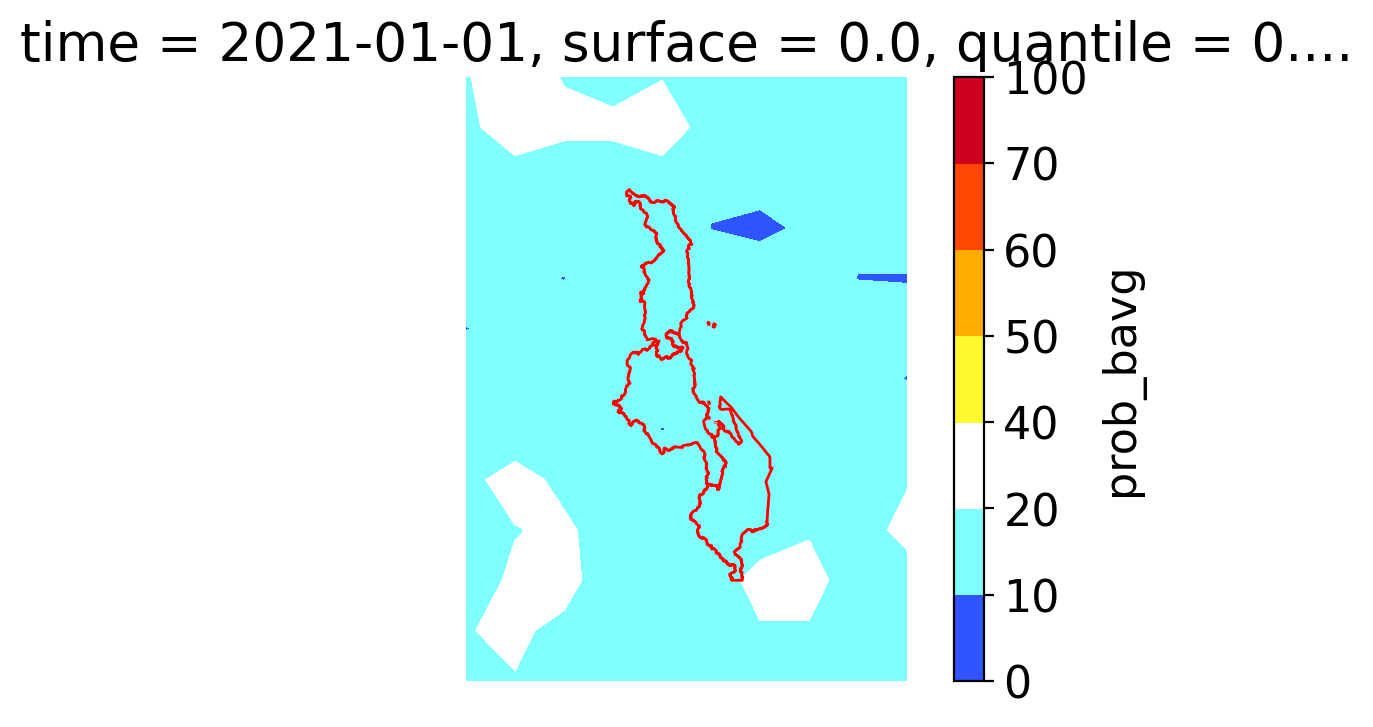

In [17]:
import xarray as xr 
from matplotlib import pyplot as plt
plt.ion()
import cartopy.crs as ccrs
# fnc='ed8f355c-5823-453c-bbdc-d4c64a038b61.nc'
# ds=xr.open_dataset(fnc)
plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
ds_ltseas_below_prob.sel(time="2021-01-01").squeeze().prob_bavg.plot.contourf(ax=ax, levels=[0,10,20,40,50,60,70,100],colors=['#3054FF','#80FFFF','#FFFFFF','#FFF730','#FFAC00','#FF4701','#CD011E'])
# ax.coastlines()
df_bound = gpd.read_file(adm1_bound_path)
df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
ax.axis("off")

In [18]:
ds_ltseas_below_prob.sel(time="2021-01-01")

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 10, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01
    surface    float64 0.0
  * latitude   (latitude) float64 -7.126 -8.126 -9.126 ... -17.13 -18.13 -19.13
  * longitude  (longitude) float64 29.67 30.67 31.67 32.67 ... 36.67 37.67 38.67
    quantile   float64 0.33
    month      (time) int64 1
Data variables:
    prob_bavg  (time, latitude, longitude) float64 19.61 23.53 ... 17.65 15.69